In [1]:
import pandas as pd
import numpy as np
import amro
import seaborn as sns
import matplotlib_inline.backend_inline
import matplotlib.pyplot as plt
from IPython.core.display import HTML

# Context for figures in jupyter notebook
sns.set(rc={"figure.dpi":200, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# My obsessive brain needs centered figures:
# https://stackoverflow.com/a/66493988
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Data
The contact matrix we are using is the same as in Tal Robin's paper:
https://doi.org/10.1371/journal.pone.0290821 its divided into two files: **wards** and **patients**


### Wards
The wards dataset contains information on each of the hospital's wards. The following are the variables in the dataset:
* Day refers to the moment in time (day). These data span 1399 consecutive days (02/01/2009 to 11/30/2012) with the first day marking day 0. 
* Ward refers to the ward the individual was in. Individuals in the same ward are assumed to have higher levels of contamination. 
* Count refers to the number of individuals per day in each of the ward. Individuals that spent the day in more than one ward are counted as percentages. For example, an individual that spent their day in three wards counts as 0.33 for each of the wards they were in. 

In [2]:
total_patients_per_ward = pd.read_csv("../data/wards_py.csv")
total_patients_per_ward.head()

,day,ward,count
0,0,1,3.0
1,0,2,8.0
2,0,3,23.0
3,0,4,16.0
4,0,5,3.0


### Patients
The patients dataset contains information on each of the patients with anonnymized MRNs. The following are the variables in the dataset:
* `day` refers to the moment in time (day). These data span 1399 consecutive days (02/01/2009 to 11/30/2012) with the first day marking day 0. 
* `ward` refers to the ward the individual was in. Individuals in the same ward are assumed to have higher levels of contamination. This ward corresponds to the one in the **wards** dataset. 
* `MRN` is an annonymized unique identifier of the patient. 
* `is_new` indicates whether the patient just came into the hospital (`is_new = 1`) or they were hospitalized the day before (`is_new = 0`). This indicator helps the contamination variable. 
* `weight` is the weight of the individual for each ward. It is calculated as: `1/(number of wards mrn was in day d)`
* `next_day` refers to the row number in which that individual appears again in the dataset in `dat + 1` (this is for speed purposes of the algorithm). Negative values imply that the individual never came back to the hospital. 

In [3]:
ward_matrix = pd.read_csv("../data/patients_py.csv")
ward_matrix.head()

,day,ward,MRN,is_new,weight,next_day
0,0,1,1,1,1.0,1510
1,0,1,2,1,1.0,1511
2,0,1,3,1,1.0,1512
3,0,2,4,1,1.0,1513
4,0,2,5,1,1.0,1514


# Model

The model is programmed in the `amro` library. It uses `C++` functions to fastly compute in parallel realizations of the model with different parameters.  You can access the `help` for a description of all of the included functions:


In [4]:
help(amro)

Help on module amro:

NAME
    amro - Module implementing a stochastic model of antimicrobial resistant organisms in a healthcare facility.

FUNCTIONS
    progress_patients_1_timestep(...) method of builtins.PyCapsule instance
        progress_patients_1_timestep(ward_matrix: Numpy.ndarray[numpy.float64] = 1, total_patients_per_ward: Numpy.ndarray[numpy.float64] = 2, parameters: Numpy.ndarray[numpy.float64] = 3, n_sims: int = 4) -> Numpy.ndarray[numpy.float64]
        
        
        @title Progress patients across all wards
        
        @description Progresses all the patients across all wards one timestep. Consider
        a group of individuals in the same ward. Let `C_i(t)` denote whether individual `i` is colonized
        `C_i(t) = 1` or not colonized `C_i(t) = 0` at time `t`. The probability of an individual being colonized
        at time `t + 1` is given by:
        
            [(1 - detected)*(1 - alpha) + detected*(1 - alpha2)]*w_i + (1 - w_i)(beta / N)*sum(w_i * C_i)

## Equations

In this section we discuss the model's equations. In particular we start with a simplified model that doesn't consider the possibility of importing cases and then we move to the model with importation. 

### Simplified model without imported cases
The model is defined for an individual $i$ with colonization status $C_{i,d} \in \{ 0, 1\}$ at day $d$. For an individual that was already in the hospital, the probability of an individual being colonized at day $d$ considering their colonization status at day $d-1$ is given by:
\begin{equation}
\begin{aligned}
    \mathbb{P}\big( C_{i,d} & = c_{i,d} | C_{i,d-1} = c_{i,d-1}\big) = \underbrace{\big(1 - \alpha(\delta_{i,d-1})\big) \cdot c_{i,d} \cdot c_{i,d-1} }_{T_{1 \to 1}} + \underbrace{\alpha(\delta_{i,d-1})  \cdot (1 - c_{i,d}) \cdot  c_{i,d-1} }_{T_{1 \to 0}} + \underbrace{\frac{\beta}{N_{w_i}^d} c_{i,d}(1 -  c_{i,d-1})  \cdot \sum\limits_{j\in w_i^{d}} c_{j,d-1}}_{T_{0 \to 1}} + \underbrace{(1 -  c_{i,d})(1 -  c_{i,d-1})  \cdot \bigg(1 - \frac{\beta}{N_{w_i}^d} \sum\limits_{j\in w_i^{d}} c_{j,d-1}\bigg)}_{T_{0 \to 0}}
\end{aligned}
\end{equation}
where $N_{w_i}^d$ and $c_{i,d} \in \left\{0,1\right\}$ are known constants, $\alpha, \beta$ represent the model's parameters. 

The variables represent the following:
* $c_{i,d}$ Colonized status of patient $i$ at day $d$ (either $0$ for not colonized or $1$ for colonized)
* $N_{w_i}^d$ Size (number of patients) of the ward where patient $i$ is hospitalized at day $d$. Sizes can be fractional: if a patient was in multiple wards in one day their contribution to each ward is proportional to the number of wards (say if a patient was in two wards they add $0.5$ to each).  
* $\beta$ Transmission rate of the colonization such that  $\beta/N_{w_i}^d$ is the probability of being colonized at day $d$. 
* $\delta_{i,d-1}$ Indicator variable of whether the colonization status of patient $i$ at day $d$ was detected (either $0$ for not detected or $1$ for detected). Only colonized individuals can be detected and the probability of detection is given by $\rho$. The probability of being detected is therefore:
 \begin{equation}
\begin{aligned}
    \mathbb{P}\big( \Delta_{i,d} & = \delta_{i,d} | \Delta_{i,d-1} = \delta_{i,d-1}\big) = \rho \cdot c_{i,d-1} \cdot (1 - \delta_{i,d-1}) + c_{i,d-1} \cdot \delta_{i,d-1}
\end{aligned}
\end{equation}
where $\Delta_{i,d}$ denotes the random detection status of individual $i$ at day $d$. 
* $\alpha(\delta_{i,d-1})$ Decolonization probability. An colonized individual can become decolonized with probability $\alpha$ that depends on whether the individual was detected or not:
\begin{equation}
    \alpha(\delta_{i,d-1}) = \begin{cases}
  \alpha_1 & \textrm{ if } \delta_{i,d-1} = 0, \\
  \alpha_2 & \textrm{ if } \delta_{i,d-1} = 1.
    \end{cases}
\end{equation}

### Complete model with imported cases
The model with importation can be written as:
\begin{equation}
    \mathbb{P}\left( C_{i,d} = c_{i,d} | C_{i,d-1} = c_{i,d-1}\right) = ( T_{1\to 1} + T_{0\to 0} + T_{1 \to 0} + T_{0\to 1} ) (1 - h_{i,d}) + \big[ \gamma \cdot  c_{i,d} + (1 - \gamma) \cdot (1 - c_{i,d})\big] h_{i,d}
\end{equation}
where $h_{i,d}$ is a known constant with values in $\left\{0,1\right\}$ and $\gamma$ is a parameter. 

The variables represent the following:
* The value $h_{i,d} = 1$ represents that the patient has just arrived into the healthcare facility while $h_{i,d} = 0$ represents the patient having already been in the facility at day $d - 1$. 
* $\gamma$ represents the probability that a newly arrived patient is already colonized (was colonized outside the healthcare facility). 

In this scenario the detection probability is different according to whether it was an imported case (detection for imported $\rho_{imp}$ or it was an already hospitalized case $\rho_{hosp}$ and is given by:

 \begin{equation}
\begin{aligned}
    \mathbb{P}\big( \Delta_{i,d} & = \delta_{i,d} | \Delta_{i,d-1} = \delta_{i,d-1}\big) = \big[\rho_{hosp} \cdot c_{i,d-1} \cdot (1 - \delta_{i,d-1}) + c_{i,d-1} \cdot \delta_{i,d-1}\big] (1 - h_{i,d}) + \big[\rho_{imp} \cdot c_{i,d-1} \cdot (1 - \delta_{i,d-1}) + c_{i,d-1} \cdot \delta_{i,d-1}\big] h_{i,d}
\end{aligned}
\end{equation}

## Running the algorithm
The algorithm works with numpy arrays so we need to convert everything to array.

In [5]:
#Convert the total patients
total_patients_per_ward = np.array(total_patients_per_ward)

#Get the initial patients to start the algorithm
initial_patients = ward_matrix[ward_matrix["day"] == 0].shape[0]

#Convert the rest of the patients
ward_matrix = np.array(ward_matrix)

Create a simulation with 100 parameters

In [6]:
#Set a seed for the numpy simulations
np.random.seed(47935)

#Assign a c++ seed
cpp_seed = np.random.randint(np.iinfo(np.int32).max)

#Create 100 simulations and run them in ~ 20 seconds
num_parameters = 100

#Initial colonized values represent the probability that each patient starts up colonized
colonized_day_0 = 0.2*np.ones(shape = (initial_patients, num_parameters))

#Initial detected values represent the probability that if a patient is colonized they will be detected
detected_day_0 = 0.9*np.ones(shape = (initial_patients, num_parameters))

#Create the parameter matrix, In this case we simulate t
parameters = np.array([
                    np.random.uniform(0.1, 0.15, num_parameters), #Alpha (clearance)
                    np.random.uniform(0.5, 0.6, num_parameters),  #Beta  (force of infection)
                    np.random.uniform(0.0, 0.05, num_parameters), #Gamma (probability imported = infected)
                    np.random.uniform(0.5, 0.6, num_parameters),  #Rho hosp  (detection for in hospital cases)
                    np.random.uniform(0.2, 0.25, num_parameters), #Alpha2 (clearance if detected)
                    np.random.uniform(0.5, 0.6, num_parameters),  #Rho outisde hospital (detection for imported cases)
                    ]).transpose()

#Run 100 simulations with the same initial state just different parameters. 
simulations_100 = amro.simulate_discrete_model(colonized_day_0, detected_day_0, ward_matrix, total_patients_per_ward, parameters, cpp_seed)

This is what the result from the simulations looks like

In [7]:
#Result is a matrix with as many rows as `ward_matrix` and each column is a simulation starting from column 6 and onwards until reaching number of simulations - 1. From number of simulations to the end of the matrix each column is a simulation and each row is 1 if detected
simulations_100[:10]

array([[ 0.,  1.,  1., ...,  0.,  1.,  0.],
       [ 0.,  1.,  2., ...,  0.,  0.,  1.],
       [ 0.,  1.,  3., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  2.,  8., ...,  1.,  0.,  0.],
       [ 0.,  2.,  9., ...,  0.,  0.,  0.],
       [ 0.,  2., 10., ...,  0.,  0.,  0.]])

You can get the total number of colonized or detected by simulation 

In [8]:
#We can aggregate the results first by getting the number of total positives per simulation per day 
#(either colonized or detected)
colonized_sims = amro.total_positive_colonized(simulations_100, n_sims=100)

#And the total number of detected per simulation per day
detected_sims = amro.total_positive_detected(simulations_100, n_sims=100)

In [9]:
#And using either the detected or the colonized get the mean and quantiles e can aggregate the results with the `summary_of_total_positive` function and obtain quantiles
summary_colonized = amro.summary_of_total_positive(colonized_sims, quantiles=np.array([0.05, 0.95]))
summary_detected  = amro.summary_of_total_positive(detected_sims, quantiles=np.array([0.05, 0.95]))

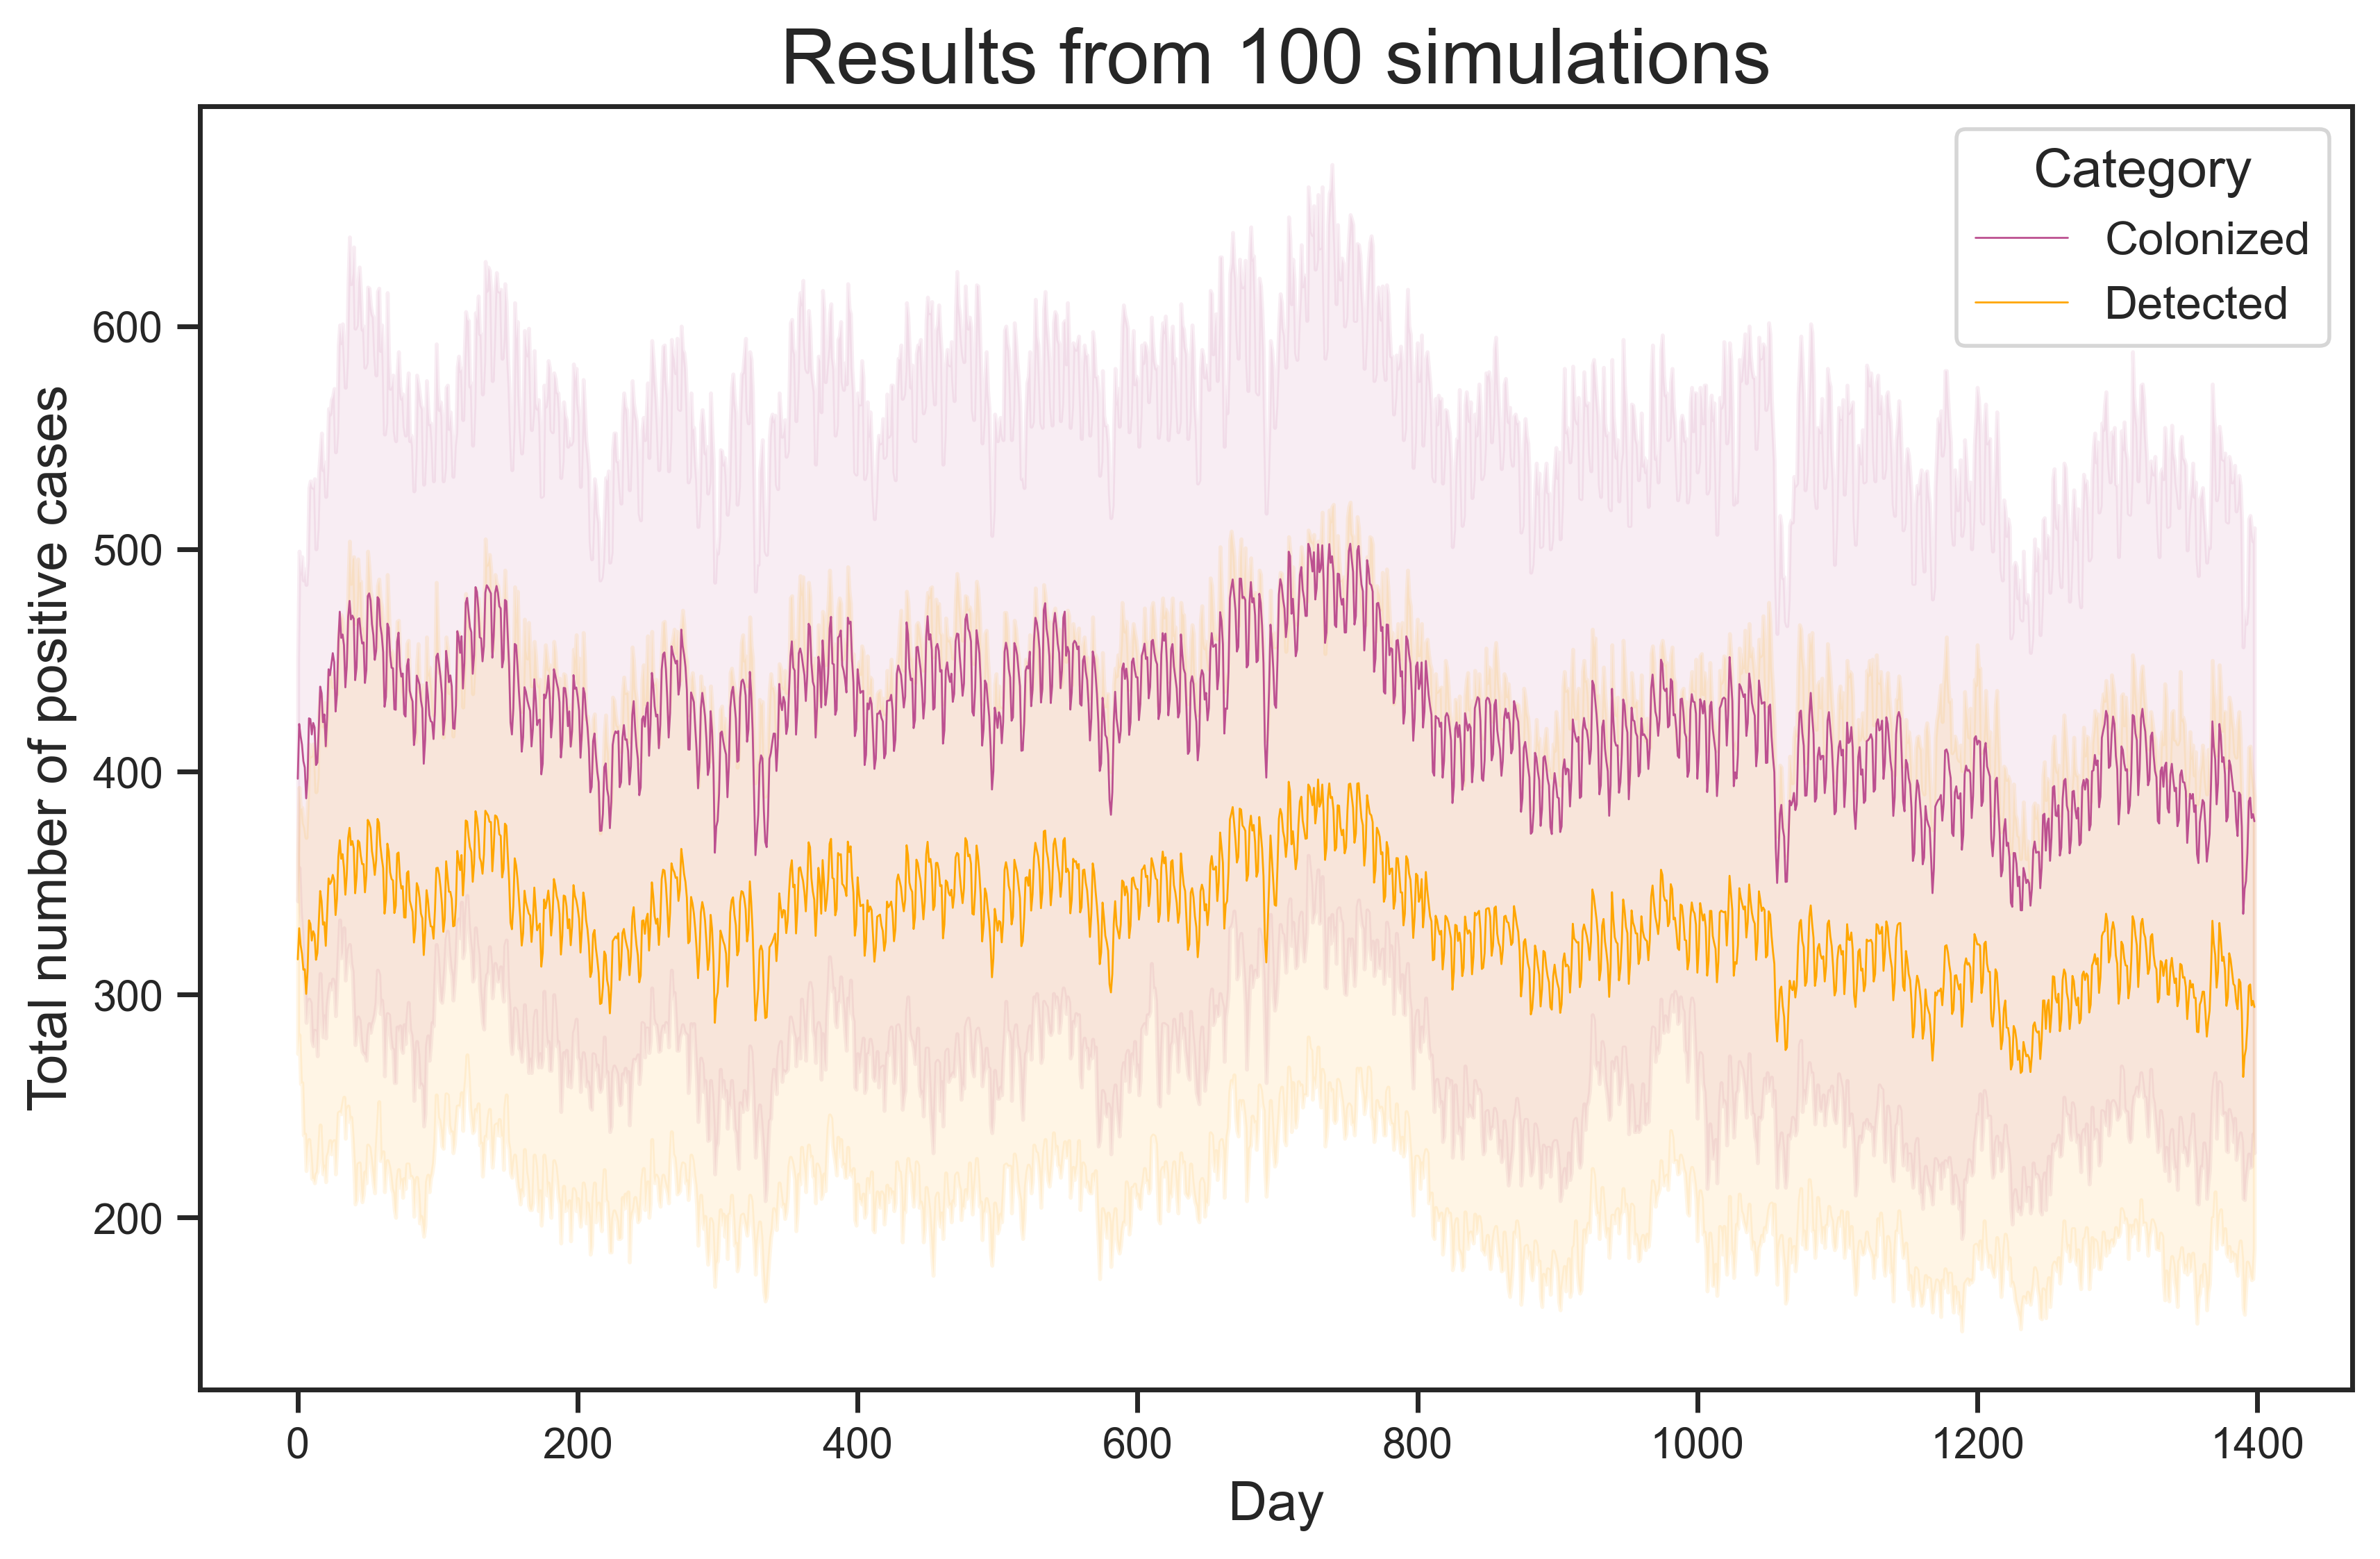

In [10]:
# Define custom colors
colonized_color = "#bc5090"  # Blue (or any other hex color you like)
detected_color = "#ffa600"   # Orange (or any other hex color you prefer)

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot colonized 
sns.lineplot(x=summary_colonized[:, 0], y=summary_colonized[:, 1], 
             linewidth=0.5, color=colonized_color, label='Colonized', ax=ax)
ax.fill_between(summary_colonized[:, 0], summary_colonized[:, 3], summary_colonized[:, 4], 
                alpha=0.1, color=colonized_color)

# Plot detected 
sns.lineplot(x=summary_detected[:, 0], y=summary_detected[:, 1], 
             linewidth=0.5, color=detected_color, label='Detected', ax=ax)
ax.fill_between(summary_detected[:, 0], summary_detected[:, 3], summary_detected[:, 4], 
                alpha=0.1, color=detected_color)

# Set title and labels
ax.set_title('Results from 100 simulations', fontsize=20)
ax.set_xlabel('Day', fontsize=14)
ax.set_ylabel('Total number of positive cases', fontsize=14)

# Add legend
ax.legend(title='Category', fontsize=12, title_fontsize=14)

# Display the plot
plt.show()